<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/INPE_CAP351_Projeto02_MLP_Lourenco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução**

Aprendizado Não Supervisionado são modelos de Machine Learnig que possuem poucos ou nenhum dado histórico para se basear e conseguir prever os resultados, eles não necessitam de um conjunto de dados que digam quais são as variáveis de saídas corretas, para modelar um algoritmo preditivo. Esses modelos conseguem criar estruturas de dados com base em relações entre as variáveis ou detectar algumas tendências.

No presente notebook contém diversos experimentos e testes com a rede Multi-layer Perceptron (MLP). Foi selecionado um datasets (não trivial) no qual foi divido em treino, validação e teste, e utilizado para treino de modelos MLP em dois problemas: classificação e regressão. Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região Amazônica. O disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície.

Foram criadas 5 topologias diferentes, variando o número de camadas. O algoritmo utilizado foi SGD, e foram aplicadas diferentes hyperparâmetros afim de avaliar o impacto do uso do Momentum e da Regularização (L2).

Este notebook pode ser acessado no **github**: https://github.com/lourencocavalcante/Neurocomputacao.git

# **Bibliotecas/Pacotes**

In [2]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=c1e6629687eba3728230158a6e8c6dbb77fa537d0bba48cd628bbff60050a703
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [47]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import IsolationForest
seaborn.set()

from google.colab import drive
drive.mount('/content/drive')

#print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset**
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície.

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [21]:
#Importando dos dados
df_rd80_dataset = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/Proj2/df_class_rd80.csv")
df_rd80_dataset = pd.DataFrame(df_rd80_dataset)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_dataset.shape[0], ', quantidade de atributos: ', df_rd80_dataset.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  13


In [22]:
print(df_rd80_dataset.dtypes)

Datetime                         object
Rain Intensity (mm/h)           float64
radar reflectivity (1/mm6m3)    float64
Liquid watercontent (g/m3)      float64
Mean weight diameter(mm)        float64
Time integration (s)            float64
Light_Rain                        int64
Moderate_Rain                     int64
Heavy_Rain                        int64
Very_Heavy_Rain                   int64
Without_Rain                      int64
Class_Rain_id                     int64
Class_Rain                       object
dtype: object


In [23]:
df_rd80_dataset = df_rd80_dataset.set_index('Datetime')

In [17]:
df_rd80_dataset.isna().sum()

Rain Intensity (mm/h)           0
radar reflectivity (1/mm6m3)    0
Liquid watercontent (g/m3)      0
Mean weight diameter(mm)        0
Time integration (s)            0
Light_Rain                      0
Moderate_Rain                   0
Heavy_Rain                      0
Very_Heavy_Rain                 0
Without_Rain                    0
Class_Rain_id                   0
Class_Rain                      0
dtype: int64

In [32]:
df_df_rd80 = df_rd80_dataset[['Rain Intensity (mm/h)','Class_Rain_id']]


**Padronização dos dados**

In [33]:
df_values = df_df_rd80.values 
df_values = df_values.reshape(-1, len(df_df_rd80.columns))

standardizer = StandardScaler().fit(df_values)
df_std = standardizer.transform(df_values)
df_std = pd.DataFrame(df_std, columns=df_df_rd80.columns)
df_std.describe()

,Rain Intensity (mm/h),Class_Rain_id
count,3.154200e+05,3.154200e+05
mean,4.036816e-17,7.352772e-17
std,1.000002e+00,1.000002e+00
min,-1.089430e-01,-2.457125e-01
25%,-1.089430e-01,-2.457125e-01
50%,-1.089430e-01,-2.457125e-01
75%,-1.089430e-01,-2.457125e-01
max,3.759545e+01,9.036319e+00


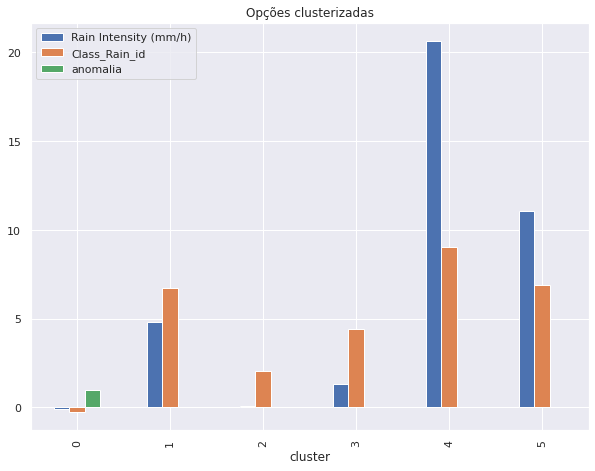

In [49]:
data_array = df_std.values
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=42)
df_std["cluster"] = kmeans.fit_predict(data_array)
df_std.groupby("cluster").aggregate("mean").plot.bar(figsize=(10,7.5))
plt.title("Opções clusterizadas")
plt.show()

O gráfico mostra que dentre os clusteres encontrados pelo modelo, há um que foge do comportamento padrão: o cluster 3. Os registros agrupados nesse cluster serão definidos como anômalos.

In [50]:
df_std['anomalia'] = 0
df_std.loc[df_std['cluster'] == 0, 'anomalia'] = 1

In [51]:
df_std.loc[(df_std['anomalia']) == 1].head(10)

,Rain Intensity (mm/h),Class_Rain_id,cluster,anomalia
0,-0.108943,-0.245713,0,1
1,-0.108943,-0.245713,0,1
2,-0.108943,-0.245713,0,1
3,-0.108943,-0.245713,0,1
4,-0.108943,-0.245713,0,1
5,-0.108943,-0.245713,0,1
6,-0.108943,-0.245713,0,1
7,-0.108943,-0.245713,0,1
8,-0.108943,-0.245713,0,1
9,-0.108943,-0.245713,0,1


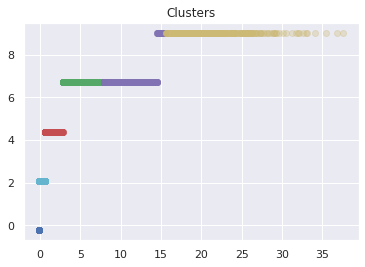

In [52]:
cor = ['b', 'g', 'r', 'c', 'm', 'y']
i=0
for cluster in df_std['cluster'].unique():
    df = df_std.loc[df_std['cluster'] == cluster]
    plt.scatter(df['Rain Intensity (mm/h)'], df['Class_Rain_id'], c=cor[i],alpha=0.3)
    i += 1
plt.title("Clusters")
plt.show()

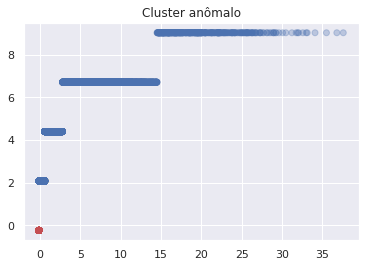

In [53]:
cor = []
for anomalia in df_std['anomalia'] :
    if anomalia == 1 :
        cor.append('r')
    else :
        cor.append('b')
plt.scatter(df_std['Rain Intensity (mm/h)'], df_std['Class_Rain_id'], c=cor,alpha=0.3)
plt.title("Cluster anômalo")
plt.show()

In [54]:
def particionaDados(X, Y, treinamento=.75, teste=.25, random_state=42):
    percentual_teste_validacao = 1 - treinamento
    X_treino, X_temp, Y_treino, Y_temp = train_test_split(X, Y, test_size=percentual_teste_validacao, 
        random_state=random_state)
    
    if(treinamento + teste < 1):
        validacao = 1 - (treinamento + teste)
        percentual_validacao = validacao / percentual_teste_validacao
        
        X_teste, X_validacao, Y_teste, Y_validacao = train_test_split(X_temp, Y_temp, test_size=percentual_validacao,
        random_state=random_state)
    else:
        X_teste = X_temp
        Y_teste = Y_temp
        X_validacao = []
        Y_validacao = [] 
   
    return (X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao)

In [55]:
def treinaKNN(k, p, X_treino, Y_treino, X_teste, Y_teste):
    classificador = KNeighborsClassifier(n_neighbors=k, p=p)
    classificador.fit(X_treino, Y_treino.ravel())

    y_pred = classificador.predict(X_teste)

    return (confusion_matrix(Y_teste, y_pred), accuracy_score(Y_teste, y_pred), classificador)

In [56]:
df_std.head()

,Rain Intensity (mm/h),Class_Rain_id,cluster,anomalia
0,-0.108943,-0.245713,0,1
1,-0.108943,-0.245713,0,1
2,-0.108943,-0.245713,0,1
3,-0.108943,-0.245713,0,1
4,-0.108943,-0.245713,0,1


In [57]:
X = df_std.iloc[:,0:2].values
Y = df_std.iloc[:,3:].values

X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao = particionaDados(X,Y,.75,.25)

len(df_std), len(X_treino), len(X_teste), len(X_validacao) , len(Y_treino), len(Y_teste), len(Y_validacao)

(315420, 236565, 78855, 0, 236565, 78855, 0)

In [ ]:
matrizes = {}
acuracias = {}
for k in [1,3,5,7]:
    treinamento = treinaKNN(k,2, X_treino, Y_treino, X_teste, Y_teste)
    matrizes[k] = treinamento[0]
    acuracias[k] = treinamento[1]

In [ ]:
for k, matriz in matrizes.items(): 
    fig, ax = plot_confusion_matrix(conf_mat=matriz, show_absolute=True, show_normed=True)
    ax.set_title('Número de Vizinhos: ' + str(k), fontsize = 15)
    plt.show()